# Graph — End‑to‑End Stress Notebook

**Goal:** build a realistic, multi‑layer biological interaction graph with **tens of thousands** of vertices and a mix of **binary edges, hyperedges, and vertex–edge (edge‑entity) links**, then **exercise every public API**: layers, presence queries, propagation (`shared` / `all`), views, analytics, set operations, aggregations, subgraph/copy, deletions, auditing, and memory usage.

In [2]:
# Robust import of Graph
import os
import random
import sys
from time import perf_counter

sys.path.insert(0, os.path.abspath(".."))  # must be the parent folder that CONTAINS 'annnet'

from annnet.core.graph import Graph

G = Graph(directed=True)


import polars as pl

In [4]:
# Parameters — choose a scale
# - DEMO runs fast on laptops
# - STRESS creates 10^4–10^5 scale objects; adjust upward to your machine limits

SCALE = "DEMO"  # "DEMO" or "STRESS"

if SCALE.upper() == "DEMO":
    N_PROTEINS = 5_00
    N_TRANSCRIPTS = 2_00
    N_METABOLITES = 1_00
    N_EDGE_ENTITIES = 40
    N_BIN_EDGES = 25_00  # binary protein-protein interactions (base layer)
    N_HYPER_COMPLEX = 1_00  # undirected complexes
    N_HYPER_CASCADE = 1_00  # directed signaling cascades
    N_vertex_EDGE_BIDIR = 2_00  # vertex<->edge-entity links (counted as pairs)
else:
    N_PROTEINS = 30_000
    N_TRANSCRIPTS = 12_000
    N_METABOLITES = 8_000
    N_EDGE_ENTITIES = 2_500
    N_BIN_EDGES = 160_000
    N_HYPER_COMPLEX = 4, 000  # use commas? We'll correct below to int
    N_HYPER_CASCADE = 4_000
    N_vertex_EDGE_BIDIR = 10_000

# fix typo for N_HYPER_COMPLEX in STRESS case
if isinstance(N_HYPER_COMPLEX, tuple):
    N_HYPER_COMPLEX = 4000

LAYERS = ["Healthy", "Stressed", "Disease", "DrugA", "DrugB"]
ORDERED_FOR_TEMPORAL = ["Healthy", "Stressed", "Disease", "DrugA", "DrugB"]

# How many parallel edges to create as duplicates between random pairs
N_PARALLEL_DUPES = max(1, N_BIN_EDGES // 20)

# Fraction of vertices seeded into each non-default layer (to make propagate='shared'/'all' meaningful)
SEED_FRAC_PER_LAYER = 0.6

In [6]:
# Helpers


def rand_weight(base=1.0, jitter=0.5):
    # positive weight with variability
    w = base + (random.random() - 0.5) * 2 * jitter
    return max(0.01, w)


def try_to_pandas(df):
    if df is None:
        return None
    if "polars" in type(df).__module__.lower():
        return df.to_pandas() if hasattr(df, "to_pandas") else None
    return df  # assume already pandas-like


def head_df(df, n=5):
    p = try_to_pandas(df)
    return p.head(n) if p is not None else None

In [8]:
# Build graph & layers
t0 = perf_counter()
G = Graph(directed=True)

for lid in LAYERS:
    G.add_layer(lid, desc=f"condition={lid}")
G.set_active_layer(LAYERS[0])
build_layers_time = perf_counter() - t0
print("Layers ready:", G.list_layers(), "active:", G.get_active_layer())

Layers ready: ['Healthy', 'Stressed', 'Disease', 'DrugA', 'DrugB'] active: Healthy


In [10]:
# ---- progress helpers ----
from time import perf_counter

try:
    from tqdm.auto import tqdm  # uses notebook bar if available

    _TQDM = True
except Exception:
    _TQDM = False


def prog_iter(it, total=None, desc="", mininterval=0.25):
    """Wrap any iterable with a progress display (tqdm if available, else no-op)."""
    if _TQDM:
        return tqdm(it, total=total, desc=desc, mininterval=mininterval, leave=False)
    return it


def batched(iterable, batch_size):
    """Yield lists of size <= batch_size (Py<3.12 compatible)."""
    buf = []
    for x in iterable:
        buf.append(x)
        if len(buf) == batch_size:
            yield buf
            buf = []
    if buf:
        yield buf

In [12]:
import numpy as np

rng = np.random.default_rng(42)

t = perf_counter()

proteins = [f"P{i}" for i in range(1, N_PROTEINS + 1)]
transcripts = [f"T{i}" for i in range(1, N_TRANSCRIPTS + 1)]
metabolites = [f"M{i}" for i in range(1, N_METABOLITES + 1)]
edge_entities = [f"EE{i}" for i in range(1, N_EDGE_ENTITIES + 1)]

# --- Seed vertices in "Healthy" ---
kinase_mask = rng.random(len(proteins)) < 0.15
G.add_vertices_bulk(
    (
        {"vertex_id": p, "kind": "protein", **({"family": "kinase"} if km else {})}
        for p, km in zip(proteins, kinase_mask)
    ),
    layer="Healthy",
)
G.add_vertices_bulk(({"vertex_id": t, "kind": "transcript"} for t in transcripts), layer="Healthy")
G.add_vertices_bulk(({"vertex_id": m, "kind": "metabolite"} for m in metabolites), layer="Healthy")

# --- Edge-entities in "Healthy" (bulk) ---
pathways = np.array(["glycolysis", "tca", "mapk", "pi3k"])
drawn_pathways = pathways[rng.integers(0, len(pathways), size=len(edge_entities))]
G.add_edge_entities_bulk(
    (
        {"edge_entity_id": ee, "role": "enzyme", "pathway": pw}
        for ee, pw in zip(edge_entities, drawn_pathways)
    ),
    layer="Healthy",
)

# --- Seed presence into other layers (bulk per layer) ---
p_keep = SEED_FRAC_PER_LAYER
for lid in LAYERS[1:]:
    pmask = rng.random(len(proteins)) < p_keep
    tmask = rng.random(len(transcripts)) < p_keep
    mmask = rng.random(len(metabolites)) < p_keep

    G.add_vertices_bulk(
        ({"vertex_id": p, "kind": "protein"} for p, keep in zip(proteins, pmask) if keep),
        layer=lid,
    )
    G.add_vertices_bulk(
        ({"vertex_id": t, "kind": "transcript"} for t, keep in zip(transcripts, tmask) if keep),
        layer=lid,
    )
    G.add_vertices_bulk(
        ({"vertex_id": m, "kind": "metabolite"} for m, keep in zip(metabolites, mmask) if keep),
        layer=lid,
    )

build_vertices_time = perf_counter() - t
print(
    "vertices done. #vertices:",
    G.number_of_vertices(),
    "Edge-entities:",
    sum(1 for k, v in G.entity_types.items() if v == "edge"),
    "time(s)=",
    round(build_vertices_time, 3),
)

vertices done. #vertices: 800 Edge-entities: 40 time(s)= 0.344


In [13]:
# Binary edges (PPIs mostly among proteins), defined in Healthy then layered variants
from time import perf_counter

t = perf_counter()

# ---------- 1) Bulk create binary edges on "Healthy" ----------
pairs = []
need = N_BIN_EDGES
names = proteins
n = len(names)

# Generate candidate pairs quickly; reject self-loops
while len(pairs) < need:
    k = min(need - len(pairs), max(1024, need // 4))
    us = random.choices(names, k=k)
    vs = random.choices(names, k=k)
    for u, v in zip(us, vs):
        if u != v:
            pairs.append((u, v))
        if len(pairs) == need:
            break

dirs = [random.random() < 0.8 for _ in range(need)]
ws = [rand_weight(1.2, 0.6) for _ in range(need)]

bulk = [
    {
        "source": u,
        "target": v,
        "weight": w,
        "edge_directed": d,
        "edge_type": "regular",
        "layer": "Healthy",
    }
    for (u, v), w, d in zip(pairs, ws, dirs)
]
ppis = G.add_edges_bulk(bulk, layer="Healthy")  # list of edge_ids

# ---------- 2) Bulk add parallel dupes ----------
if ppis and N_PARALLEL_DUPES > 0:
    chosen = random.choices(ppis, k=N_PARALLEL_DUPES)
    par_edges = []
    for eid in chosen:
        u, v, _ = G.edge_definitions[eid]
        par_edges.append(
            {
                "source": u,
                "target": v,
                "weight": rand_weight(1.0, 0.3),
                "edge_type": "regular",
                "layer": "Healthy",
            }
        )
    G.add_edges_bulk(par_edges, layer="Healthy")

# ---------- 3) Bulk per-layer variants ----------
base_w = {eid: G.edge_weights[eid] for eid in ppis}

for lid in LAYERS[1:]:
    # Add all PPI edges to this layer in one shot
    G.add_edges_to_layer_bulk(lid, ppis)

    # Compute modifiers and upsert all weights for this layer at once
    weights_rows = []
    for eid in ppis:
        bw = base_w[eid]
        factor = {
            "Stressed": rand_weight(1.10, 0.10),
            "Disease": (0.7 if random.random() < 0.4 else rand_weight(1.30, 0.15)),
            "DrugA": rand_weight(0.9, 0.25),
            "DrugB": rand_weight(1.2, 0.20),
        }[lid]
        weights_rows.append((eid, {"weight": bw * factor, "note": f"layer={lid}"}))

    G.set_edge_layer_attrs_bulk(lid, weights_rows)

build_binary_time = perf_counter() - t
print(
    "Binary edges built:",
    len(ppis),
    "total edges now:",
    G.number_of_edges(),
    "time(s)=",
    round(build_binary_time, 3),
)

Binary edges built: 2500 total edges now: 2625 time(s)= 0.137


In [14]:
# Propagation semantics via add_edge(..., propagate=...)
t = perf_counter()
# Ensure varied vertex presence across layers for a few pairs
pairs = [(random.choice(proteins), random.choice(transcripts)) for _ in range(2000)]
for u, v in pairs:
    # 'shared': only layers where both endpoints already present
    G.add_edge(
        u, v, layer="Healthy", edge_type="regular", weight=rand_weight(0.8, 0.2), propagate="shared"
    )
pairs2 = [(random.choice(proteins), random.choice(metabolites)) for _ in range(2000)]
for u, v in pairs2:
    # 'all': appears everywhere either endpoint exists (pulls other endpoint in)
    G.add_edge(
        u, v, layer="Healthy", edge_type="regular", weight=rand_weight(0.8, 0.2), propagate="all"
    )

build_propagation_time = perf_counter() - t
print("Propagation examples added (shared/all).")

Propagation examples added (shared/all).


In [16]:
# Hyperedges: undirected complexes, directed cascades
t = perf_counter()

complex_ids = []
for _ in range(N_HYPER_COMPLEX):
    size = random.choice([3, 4, 5, 6])
    members = set(random.sample(proteins, size))
    hid = G.add_hyperedge(
        members=members, layer="Healthy", weight=rand_weight(1.0, 0.2), tag="complex"
    )
    complex_ids.append(hid)
    for lid in LAYERS[1:]:
        G.add_edge_to_layer(lid, hid)

cascade_ids = []
tries = 0
while len(cascade_ids) < N_HYPER_CASCADE and tries < N_HYPER_CASCADE * 5:
    tries += 1
    head = set(random.sample(proteins, random.choice([1, 2])))
    tail = set(random.sample(proteins, random.choice([2, 3, 4])))
    if head & tail:
        continue
    hid = G.add_hyperedge(
        head=head, tail=tail, layer="Healthy", weight=rand_weight(1.0, 0.4), tag="cascade"
    )
    cascade_ids.append(hid)
    for lid in LAYERS[1:]:
        G.add_edge_to_layer(lid, hid)

build_hyper_time = perf_counter() - t
print("Hyperedges built: complexes=", len(complex_ids), "cascades=", len(cascade_ids))

Hyperedges built: complexes= 100 cascades= 100


In [18]:
# vertex–edge (edge-entity) reactions: A -> EE -> B (bidir variants)
t = perf_counter()
for _ in range(N_vertex_EDGE_BIDIR):
    ee = random.choice(edge_entities)
    s = random.choice(proteins + transcripts + metabolites)
    tvertex = random.choice(proteins + transcripts + metabolites)
    G.add_edge(s, ee, layer="Healthy", edge_type="vertex_edge", weight=rand_weight(1.0, 0.5))
    G.add_edge(ee, tvertex, layer="Healthy", edge_type="vertex_edge", weight=rand_weight(1.0, 0.5))
    # reflect into other layers
    for lid in LAYERS[1:]:
        G.add_edge_to_layer(lid, list(G.get_edge_ids(s, ee))[-1])
        G.add_edge_to_layer(lid, list(G.get_edge_ids(ee, tvertex))[-1])

build_vertexedge_time = perf_counter() - t
print("vertex–edge reaction links added (pairs):", N_vertex_EDGE_BIDIR)

vertex–edge reaction links added (pairs): 200


In [20]:
# Sanity & counts
print("vertices:", G.number_of_vertices(), "Edges:", G.number_of_edges())
assert G.number_of_vertices() > 0 and G.number_of_edges() > 0

# Edge-entity count
edge_entity_count = sum(
    1 for _id, et in G.entity_types.items() if et == "edge" and _id in set(edge_entities)
)
print("Edge-entities:", edge_entity_count)
assert edge_entity_count == len(edge_entities)

vertices: 800 Edges: 7225
Edge-entities: 40


In [24]:
# Views & Top edges per layer
try:
    for lid in LAYERS:
        EV = G.edges_view(layer=lid, resolved_weight=True)
        print(
            f"[{lid}] edges_view rows:", getattr(EV, "height", getattr(EV, "shape", ["?", "?"])[0])
        )
        # filter binary only, sort by effective weight
        if pl is not None and isinstance(EV, pl.DataFrame):
            top = (
                EV.filter(pl.col("kind") == "binary")
                .sort("effective_weight", descending=True)
                .select(["edge_id", "source", "target", "effective_weight"])
                .head(5)
            )
            print(f"Top 5 binary edges in {lid}:\n", top)
        else:
            # Try pandas-like
            try:
                df = EV
                if hasattr(df, "query"):
                    bf = (
                        df.query("kind == 'binary'")
                        .sort_values("effective_weight", ascending=False)
                        .head(5)
                    )
                    print(bf[["edge_id", "source", "target", "effective_weight"]])
            except Exception:
                pass
except Exception as e:
    print("edges_view failed softly:", e)

try:
    NV = G.vertices_view()
    LV = G.layers_view()
    print("vertices view cols:", getattr(NV, "columns", None))
    print("Layers view cols:", getattr(LV, "columns", None))
except Exception as e:
    print("vertices_view/layers_view failed softly:", e)

[Healthy] edges_view rows: 7225
Top 5 binary edges in Healthy:
 shape: (5, 4)
┌───────────┬────────┬────────┬──────────────────┐
│ edge_id   ┆ source ┆ target ┆ effective_weight │
│ ---       ┆ ---    ┆ ---    ┆ ---              │
│ str       ┆ str    ┆ str    ┆ f64              │
╞═══════════╪════════╪════════╪══════════════════╡
│ edge_1237 ┆ P281   ┆ P482   ┆ 1.799852         │
│ edge_967  ┆ P121   ┆ P103   ┆ 1.798975         │
│ edge_173  ┆ P65    ┆ P179   ┆ 1.798059         │
│ edge_2040 ┆ P447   ┆ P4     ┆ 1.797343         │
│ edge_286  ┆ P492   ┆ P481   ┆ 1.797247         │
└───────────┴────────┴────────┴──────────────────┘
[Stressed] edges_view rows: 7225
Top 5 binary edges in Stressed:
 shape: (5, 4)
┌───────────┬────────┬────────┬──────────────────┐
│ edge_id   ┆ source ┆ target ┆ effective_weight │
│ ---       ┆ ---    ┆ ---    ┆ ---              │
│ str       ┆ str    ┆ str    ┆ f64              │
╞═══════════╪════════╪════════╪══════════════════╡
│ edge_967  ┆ P121   ┆ P10

In [26]:
# Presence queries
any_e = next(iter(G.edge_to_idx.keys()))
print("Edge presence across layers:", G.edge_presence_across_layers(edge_id=any_e))

any_p = random.choice(proteins)
print("vertex presence across layers:", G.vertex_presence_across_layers(any_p))

# Hyperedge presence by members and head/tail
if complex_ids:
    m = random.choice(complex_ids)
    members = G.hyperedge_definitions[m].get("members", set())
    if members:
        print(
            "Hyperedge presence (members):",
            G.hyperedge_presence_across_layers(members=set(members)),
        )
if cascade_ids:
    h = random.choice(cascade_ids)
    hd = G.hyperedge_definitions[h]
    if hd.get("head") and hd.get("tail"):
        print(
            "Hyperedge presence (head/tail):",
            G.hyperedge_presence_across_layers(head=set(hd["head"]), tail=set(hd["tail"])),
        )

Edge presence across layers: ['Healthy', 'Stressed', 'Disease', 'DrugA', 'DrugB']
vertex presence across layers: ['Healthy', 'Stressed', 'Disease', 'DrugA', 'DrugB']
Hyperedge presence (members): {'Healthy': ['edge_6655'], 'Stressed': ['edge_6655'], 'Disease': ['edge_6655'], 'DrugA': ['edge_6655'], 'DrugB': ['edge_6655']}
Hyperedge presence (head/tail): {'Healthy': ['edge_6733'], 'Stressed': ['edge_6733'], 'Disease': ['edge_6733'], 'DrugA': ['edge_6733'], 'DrugB': ['edge_6733']}


In [28]:
# Traversal
q = random.choice(proteins)
print(f"Neighbors({q}) sample:", G.neighbors(q)[:10])
print(f"Out({q}) sample:", G.out_neighbors(q)[:10])
print(f"In({q}) sample:", G.in_neighbors(q)[:10])

Neighbors(P284) sample: ['P37', 'P51', 'M2', 'P56', 'T94', 'M63', 'T156', 'T1']
Out(P284) sample: ['P37', 'P51', 'M2', 'P56', 'T94', 'M63', 'T156', 'T1']
In(P284) sample: ['P88', 'P80']


In [30]:
# Layer analytics, conserved/specific, temporal
stats = G.layer_statistics()
print("Layer stats keys:", list(stats.keys())[:5])

conserved = G.conserved_edges(min_layers=len(LAYERS))
print("Conserved edges (present in all layers):", len(conserved))

disease_specific = G.layer_specific_edges("Disease")
print("Disease-specific edges:", len(disease_specific))

changes_e = G.temporal_dynamics(ORDERED_FOR_TEMPORAL, metric="edge_change")
changes_n = G.temporal_dynamics(ORDERED_FOR_TEMPORAL, metric="vertex_change")
print("Temporal edge changes entries:", len(changes_e), "vertex changes entries:", len(changes_n))

Layer stats keys: ['Healthy', 'Stressed', 'Disease', 'DrugA', 'DrugB']
Conserved edges (present in all layers): 5303
Disease-specific edges: 0
Temporal edge changes entries: 4 vertex changes entries: 4


In [32]:
# Layer set ops and derived layers
u = G.layer_union(["Healthy", "Stressed"])
i = G.layer_intersection(["Healthy", "Stressed"])
d = G.layer_difference("Healthy", "Stressed")
print("Union edges>=intersection edges:", len(u["edges"]) >= len(i["edges"]))

lid_u = G.create_layer_from_operation("HS_union", u, desc="H∪S")
lid_i = G.create_layer_from_operation("HS_intersection", i, desc="H∩S")
lid_d = G.create_layer_from_operation("H_minus_S", d, desc="H\\S")
print(
    "Derived layers exist:",
    G.has_layer("HS_union"),
    G.has_layer("HS_intersection"),
    G.has_layer("H_minus_S"),
)

# Aggregations
G.create_aggregated_layer(["Healthy", "Stressed"], "Agg_union", method="union", tag="agg_u")
G.create_aggregated_layer(
    ["Healthy", "Stressed"], "Agg_intersection", method="intersection", tag="agg_i"
)
print("Aggregated layers added.")

Union edges>=intersection edges: True
Derived layers exist: True True True
Aggregated layers added.


In [34]:
# Edge list & global counts
el = G.edge_list()
print("Edge list tuple length check (u,v,kind,id):", all(len(t) == 4 for t in el))
print("Global entity/edge counts:", G.global_entity_count(), G.global_edge_count())

Edge list tuple length check (u,v,kind,id): True
Global entity/edge counts: 840 7225


In [36]:
# Subgraph & copy
SG = G.subgraph_from_layer("DrugB", resolve_layer_weights=True)
print("DrugB subgraph vertices/edges:", SG.number_of_vertices(), SG.number_of_edges())

CP = G.copy()
# quick consistency checks
assert set(CP.vertices()) == set(G.vertices())
assert set(CP.edges()) == set(G.edges())
any_hyper = next(e for e, k in G.edge_kind.items() if k == "hyper")
assert CP.edge_kind.get(any_hyper) == "hyper"
for lid in G.list_layers(include_default=True):
    assert CP._layers[lid]["vertices"] == G._layers[lid]["vertices"]
    assert CP._layers[lid]["edges"] == G._layers[lid]["edges"]
print("Deep copy OK.")

DrugB subgraph vertices/edges: 783 6225
Deep copy OK.


In [38]:
# Removals: drop a slice of vertices/edges

# Drop ~1% of proteins
drop_vertices = random.sample(proteins, max(1, len(proteins) // 100))
G.remove_vertices(drop_vertices)  # one pass

# Drop up to 500 edges
drop_edges = list(G.edge_to_idx.keys())[: min(500, len(G.edge_to_idx))]
G.remove_edges(drop_edges)  # one pass

print("After removals: vertices=", G.number_of_vertices(), "edges=", G.number_of_edges())

After removals: vertices= 795 edges= 6617


In [40]:
# Audit & memory
audit = G.audit_attributes()
mem_bytes = G.memory_usage()
print("Audit keys:", list(audit.keys())[:10])
print("Approx memory usage (bytes):", int(mem_bytes))

Audit keys: ['extra_vertex_rows', 'extra_edge_rows', 'missing_vertex_rows', 'missing_edge_rows', 'invalid_edge_layer_rows']
Approx memory usage (bytes): 1587545


Build timings (seconds)                 stage   seconds
0  build_binary_edges  0.136894
1    build_hyperedges  0.036640
2        build_layers  0.002665
3    build_vertexedge  0.473448
4      build_vertices  0.343702


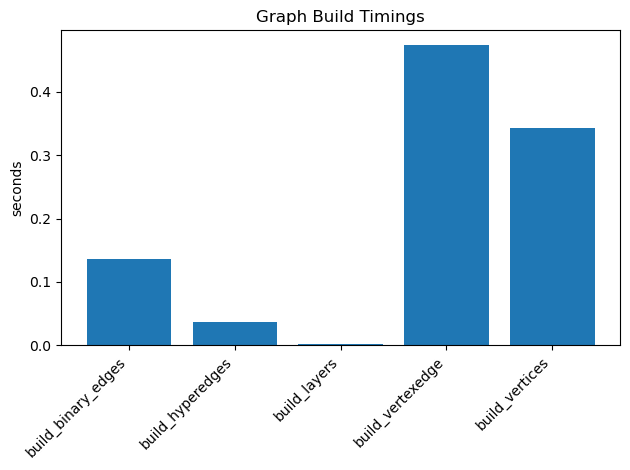

In [42]:
# Timing summary
import pandas as pd

timings = {
    "build_layers": build_layers_time,
    "build_vertices": build_vertices_time,
    "build_binary_edges": build_binary_time,
    "build_hyperedges": build_hyper_time,
    "build_vertexedge": build_vertexedge_time,
}

df = pd.DataFrame(sorted(timings.items(), key=lambda x: x[0]), columns=["stage", "seconds"])

print("Build timings (seconds)", df)

# Simple chart
import matplotlib.pyplot as plt

plt.figure()
plt.bar(df["stage"], df["seconds"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("seconds")
plt.title("Graph Build Timings")
plt.tight_layout()
plt.show()

In [78]:
from pathlib import Path

out_dir = Path('stress'); out_dir.mkdir(exist_ok=True, parents=True)
demo_path = out_dir/'demo.annnet'

G.write(demo_path, overwrite=True)  # lossless save
print('Wrote:', demo_path)

import annnet
# Round-trip check
G2 = annnet.Graph.read(demo_path)
print('Round-trip OK?', (G2.num_vertices, G2.num_edges) == (G.num_vertices, G.num_edges))

Wrote: stress\demo.annnet
Round-trip OK? True
